In [1]:
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 22
plt.rcParams['lines.linewidth'] = 3
import seaborn as sns
# sns.set_context('talk|')?
import scipy.stats as ss
import math
from scipy.integrate import simpson, trapezoid
import numpy as np

import scipy.interpolate as interpolate
from scipy.interpolate import UnivariateSpline, interp1d
from ipywidgets import interact
from scipy import integrate
import scipy.stats as ss

import riskSingleObserverValuation as model
import tools as tools

In [2]:

import riskSingleObserverValuation as model
import tools as tools


In [3]:
type = "cdf_prior"
line_frac = 0.0

2.0


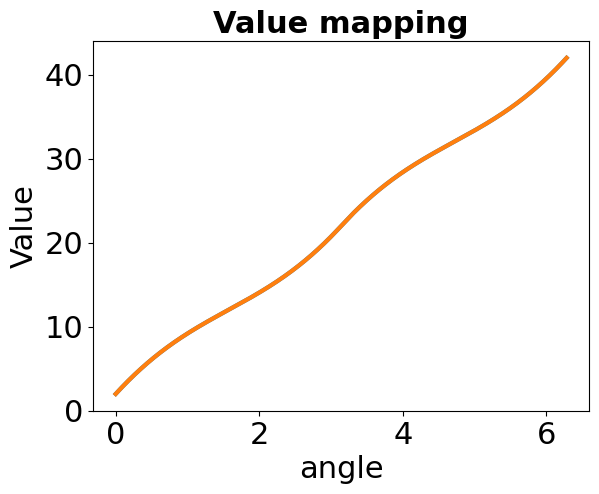

In [5]:
plt.plot(tools.stim_ori_grid, tools.value_function_ori(tools.stim_ori_grid, type, line_frac))

plt.plot(tools.stim_ori_grid,(integrate.cumtrapz(tools.prior_ori(tools.stim_ori_grid), tools.stim_ori_grid, initial=0.0))*tools.factor_val+tools.min_val)

print(min(tools.value_function_ori(tools.stim_ori_grid, type, line_frac)))

plt.ylabel("Value")
plt.xlabel("angle")
plt.title("Value mapping", size = 22,fontweight="bold")

plt.savefig('/Users/sbedi/Downloads/teig.png',dpi=300, bbox_inches = "tight")


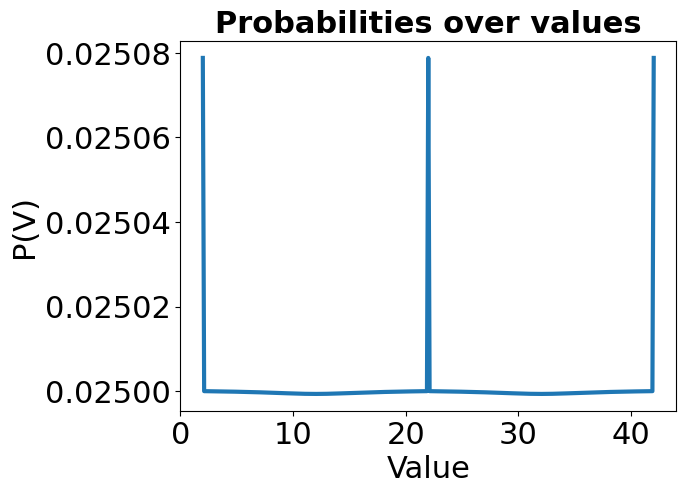

In [6]:

stim_val_grid, ps = model.prior_val(type, line_frac)

plt.plot(stim_val_grid, ps)

trapezoid(ps, stim_val_grid)

plt.ylabel("P(V)")
plt.xlabel("Value")
plt.title("Probabilities over values", size = 22,fontweight="bold")

plt.savefig('/Users/sbedi/Downloads/teig.png',dpi=300, bbox_inches = "tight")


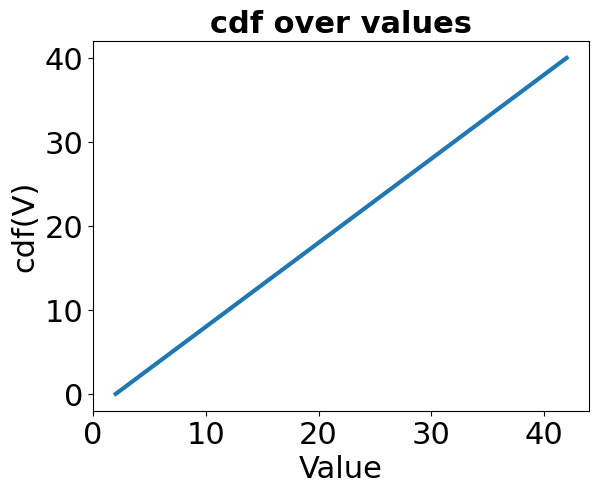

In [7]:
# stim_val_grid, ps = model.prior_val(type)
rep_val_grid, cdf_val = model.cdf_val(type)

plt.plot(rep_val_grid, cdf_val)

plt.ylabel("cdf(V)")
plt.xlabel("Value")
plt.title("cdf over values", size = 22,fontweight="bold")

plt.savefig('/Users/sbedi/Downloads/teig.png',dpi=300, bbox_inches = "tight")


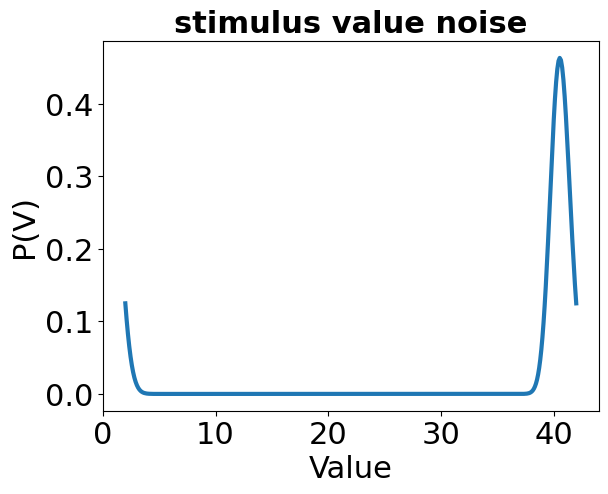

In [8]:
stim_val_grid, ps = model.stimulus_val_noise(1.95*np.pi, 100, model.stim_ori_grid, type)

plt.plot(stim_val_grid, ps[0,:])

plt.ylabel("P(V)")
plt.xlabel("Value")
plt.title("stimulus value noise", size = 22,fontweight="bold")

plt.savefig('/Users/sbedi/Downloads/teig.png',dpi=300, bbox_inches = "tight")


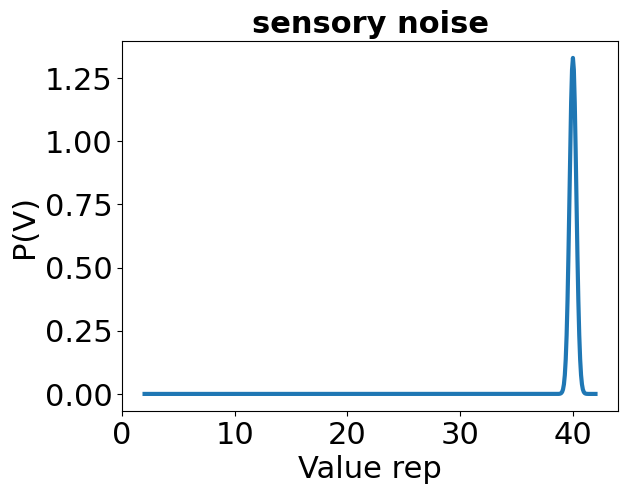

In [12]:
ps = model.sensory_noise(40, 0.3, model.rep_val_grid, type)

plt.plot(model.rep_val_grid, ps)

plt.ylabel("P(V)")
plt.xlabel("Value rep")
plt.title("sensory noise", size = 22,fontweight="bold")

plt.savefig('/Users/sbedi/Downloads/teig.png',dpi=300, bbox_inches = "tight")

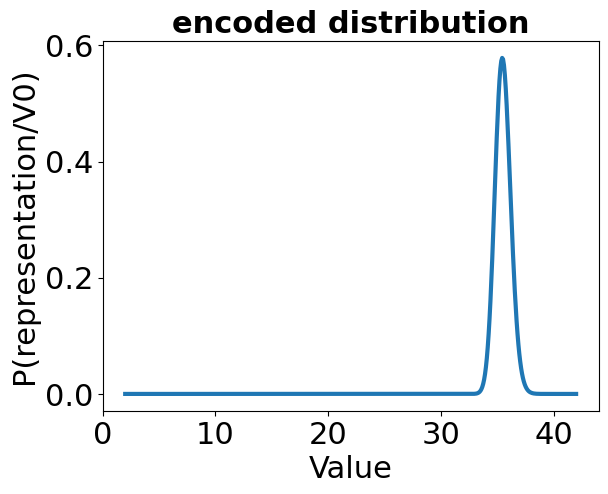

In [10]:
p_m_given_val0, p_m_given_val = model.value_efficient_encoding(164./90.*np.pi, 100, 0.07, type)

plt.plot(model.rep_val_grid, p_m_given_val0[0])

plt.ylabel("P(representation/V0)")
plt.xlabel("Value")
plt.title("encoded distribution", size = 22,fontweight="bold")

plt.savefig('/Users/sbedi/Downloads/teig.png',dpi=300, bbox_inches = "tight")



[[0.50003989]]


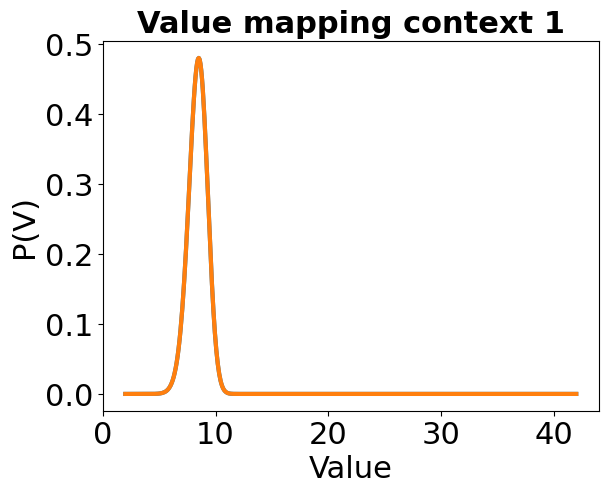

In [5]:

theta0 = [25/90.*np.pi]
kappa_s = 100
sigma_rep = 0.1 #0.2

risk_prob = 1.0
type = "cdf_prior"

safe_value, safe_prob = model.value_bayesian_decoding(theta0, kappa_s, sigma_rep, type)
rr, risky_prob = model.risky_value_dist(theta0, kappa_s, sigma_rep, risk_prob, type)

plt.plot(safe_value, safe_prob[0])
plt.plot(rr, risky_prob[0])

p_chose_risky = tools.diff_dist(safe_value, risky_prob, safe_prob)
print(p_chose_risky)

plt.xlabel("Value")
plt.ylabel("P(V)")
plt.title("Value mapping context 1", size = 22,fontweight="bold")

plt.savefig('/Users/sbedi/Downloads/testfig.png',dpi=300, bbox_inches = "tight")


In [7]:
safe_value

array([ 2.        ,  2.1169867 ,  2.2332361 ,  2.34874838,  2.46352382,
        2.57756284,  2.69086597,  2.80343383,  2.91526718,  3.0263669 ,
        3.13673398,  3.24636951,  3.35527473,  3.46345095,  3.57089963,
        3.67762235,  3.78362076,  3.88889668,  3.993452  ,  4.09728874,
        4.20040905,  4.30281517,  4.40450946,  4.50549439,  4.60577255,
        4.70534663,  4.80421945,  4.90239392,  4.99987307,  5.09666003,
        5.19275807,  5.28817053,  5.38290088,  5.47695269,  5.57032964,
        5.66303552,  5.75507422,  5.84644974,  5.93716617,  6.02722774,
        6.11663874,  6.2054036 ,  6.29352682,  6.38101302,  6.46786691,
        6.55409332,  6.63969717,  6.72468345,  6.80905729,  6.8928239 ,
        6.97598857,  7.0585567 ,  7.1405338 ,  7.22192545,  7.30273732,
        7.38297518,  7.46264491,  7.54175244,  7.62030382,  7.69830517,
        7.77576272,  7.85268276,  7.92907167,  8.00493593,  8.08028208,
        8.15511677,  8.2294467 ,  8.30327867,  8.37661955,  8.44

In [8]:
safe_prob

array([[1.46251323e-09, 2.32558256e-09, 3.72718023e-09, 5.99724586e-09,
        9.68307703e-09, 1.56814451e-08, 2.54633461e-08, 4.14429674e-08,
        6.75819352e-08, 1.10375297e-07, 1.80452292e-07, 2.95157852e-07,
        4.82679637e-07, 7.88573871e-07, 1.28594452e-06, 2.09105910e-06,
        3.38683138e-06, 5.45731280e-06, 8.73699720e-06, 1.38791845e-05,
        2.18476879e-05, 3.40357250e-05, 5.24150676e-05, 7.97179205e-05,
        1.19654232e-04, 1.77168733e-04, 2.58744823e-04, 3.72765529e-04,
        5.29943679e-04, 7.43832867e-04, 1.03142715e-03, 1.41385098e-03,
        1.91713265e-03, 2.57304435e-03, 3.41998186e-03, 4.50384503e-03,
        5.87886849e-03, 7.60834012e-03, 9.76513301e-03, 1.24319668e-02,
        1.57013065e-02, 1.96748044e-02, 2.44621901e-02, 3.01795265e-02,
        3.69467601e-02, 4.48845248e-02, 5.41101872e-02, 6.47331668e-02,
        7.68496122e-02, 9.05365702e-02, 1.05845840e-01, 1.22797762e-01,
        1.41375237e-01, 1.61518313e-01, 1.83119698e-01, 2.060215

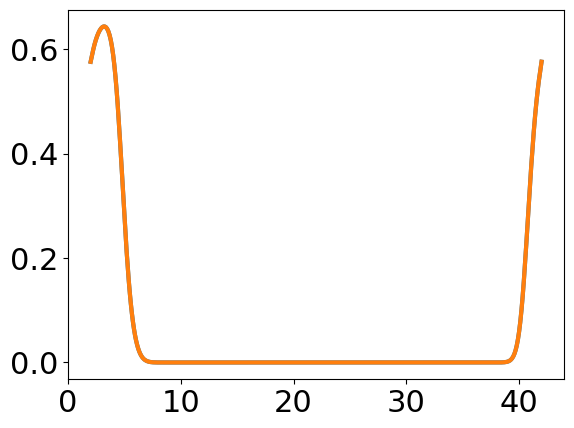

In [4]:

plt.plot(safe_value, safe_prob[0])
plt.plot(rr, risky_prob[0])


In [6]:
abs(trapezoid(safe_value, safe_prob[0], axis = -1))

0.9999999414994708

# risk simulations

# comparing models : same noise regimes fopr safe and risky option

In [5]:
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 22
plt.rcParams['lines.linewidth'] = 3
import seaborn as sns
# sns.set_context('talk|')
import scipy.stats as ss
import math
from scipy.integrate import simpson, trapezoid
import numpy as np

import scipy.interpolate as interpolate
from scipy.interpolate import UnivariateSpline, interp1d
from ipywidgets import interact
from scipy import integrate
import scipy.stats as ss

import riskSingleObserverValuation as model
import tools as tools

In [6]:

def find_rnp(stim_noise, rep_noise, type, risk_prob, experimentEffects):

    # Getting all the values from actual transformation
    end = int(experimentEffects[-3:])-1
    start = int(experimentEffects[0:2])+1
    
    if (type=="prior" or type=="linearPrior" or type=="curvedPrior"):
        start_safe = float(tools.inverse_monotonic(tools.value_function_ori(start/90.*np.pi, type)/1.5, type))
        safe_angles =  np.linspace(end/90., start_safe/90., int(end-start_safe+1))*np.pi
    else:
        end_safe = float(tools.inverse_monotonic(tools.value_function_ori(end/90.*np.pi, type)/1.5, type))
        safe_angles =  np.linspace(start/90., end_safe/90., int(start+end_safe+1))*np.pi
    
    rnp = np.zeros(len(safe_angles))
    safeVals = np.zeros(len(safe_angles))

    for i in range(len(safe_angles)):
        if (type=="prior" or type=="linearPrior" or type=="curvedPrior"):
            interval = float(tools.inverse_monotonic(tools.value_function_ori(safe_angles[i], type), type)-tools.inverse_monotonic(tools.value_function_ori(safe_angles[i], type)*1.5, type))
            rangeOri = np.linspace(safe_angles[i],  safe_angles[i]-(interval/90.*np.pi), 50)
        else:
            interval = abs(float(tools.inverse_monotonic(tools.value_function_ori(safe_angles[i], type), type)-tools.inverse_monotonic(tools.value_function_ori(safe_angles[i], type)*1.5, type)))
            rangeOri = np.linspace(safe_angles[i],  safe_angles[i]+(interval/90.*np.pi), 50)

        safeVal = float(tools.value_function_ori(safe_angles[i], type))
        safeVals[i] = safeVal
        val_range = tools.value_function_ori(rangeOri, type)
        riskyVal_range = risk_prob*tools.value_function_ori(rangeOri, type)

        # getting inferred safe values
        safe_value, safe_prob = model.value_bayesian_decoding(safe_angles[i], stim_noise, rep_noise , type)
        rr, risky_prob = model.risky_value_dist((rangeOri), stim_noise, rep_noise, risk_prob, type)

        # Risk attitudes 
        p_chose_risky = tools.diff_dist(safe_value, risky_prob, safe_prob)
        rnp[i] = tools.get_rnp(safeVal, val_range, p_chose_risky, risk_prob)

    return safe_angles, safeVals, rnp



/Users/sbedi/git/Information-and-Value/encoding_decoding/riskSingleObserverValuation.py:137: RuntimeWarning: invalid value encountered in true_divide
  p_val_given_m = p_val_given_m / trapezoid(p_val_given_m, safe_value, axis=0)[np.newaxis,:]


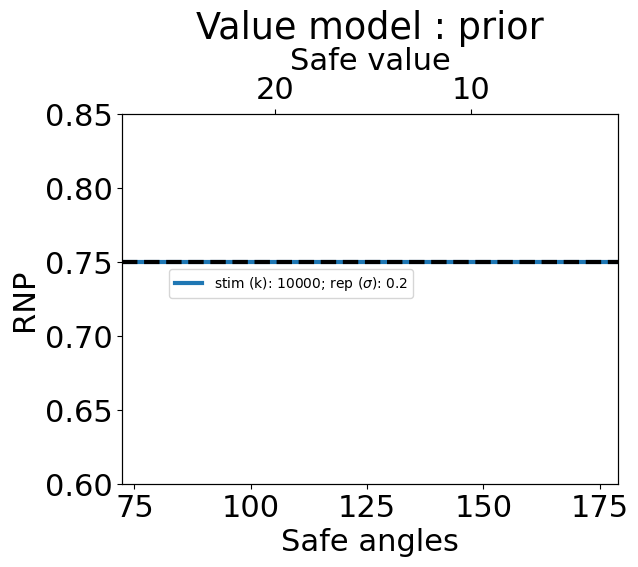

In [7]:
# setting parameters
experimentEffects = "00to180"#"00to45"
risk_prob = 0.75
type = "prior" 

# changeable parameters
stim_list = [10000]
rep_list = [0.2]#[0.2, 0.14, 0.1, 0.07, 0.05, 0.035]

fig = plt.figure()
ax1 = fig.add_subplot(111)

for stim_noise in stim_list:
    for rep_noise in rep_list:

        safe_angles, safeVals, rnp = find_rnp(stim_noise, rep_noise, type, risk_prob, experimentEffects)
        ax1.set_ylim(0.6, 0.85)
        ax1.set_xlim(min(safe_angles*90./np.pi), max(safe_angles*90./np.pi))

        text = "stim (k): "+ str(stim_noise)+"; rep ($\sigma$): "+str(rep_noise)
        ax1.plot(safe_angles[:]*90./np.pi, rnp[:], label = text)


        ax2 = ax1.twiny()
        if (type=="prior" or type=="linearPrior" or type=="curvedPrior"):
            ax2.set_xlim(max(safeVals), min(safe_angles))

        ax2.plot(safeVals, np.ones(len(safeVals))/1.3, alpha=0.0)

ax1.axhline(risk_prob, c='k', ls='--')
ax1.legend(bbox_to_anchor=(0.6, 0.6), prop={'size': 10})

ax2.set_xlabel("Safe value")
ax1.set_xlabel("Safe angles")
ax1.set_ylabel("RNP")
ax1.set_title("Value model : " + type) 


plt.savefig('/Users/sbedi/Downloads/testfig.png',dpi=300, bbox_inches = "tight")

# different noises

In [13]:

def find_rnp_diffNoises(safeNoise, riskyNoise, type, risk_prob, experimentEffects):

    # Getting all the values from actual transformation
    end = int(experimentEffects[-3:]) - 1
    start = int(experimentEffects[0:2]) + 1

    if (type=="prior" or type=="linearPrior" or type=="curvedPrior"):
        start_safe = tools.inverse_monotonic(tools.value_function_ori(start/90.*np.pi, type)/1.5, type)
        safe_angles =  np.linspace(end/90., start_safe/90., int(end-start_safe+1))*np.pi
    else:
        end_safe = tools.inverse_monotonic(tools.value_function_ori(end/90.*np.pi, type)/1.5, type)
        safe_angles =  np.linspace(start/90., end_safe/90., int(start+end_safe+1))*np.pi

    rnp = np.zeros(len(safe_angles))
    safeVals = np.zeros(len(safe_angles))

    for i in range(len(safe_angles)):
        if (type=="prior" or type=="linearPrior" or type=="curvedPrior"):
            interval = float(tools.inverse_monotonic(tools.value_function_ori(safe_angles[i], type), type)-tools.inverse_monotonic(tools.value_function_ori(safe_angles[i], type)*1.5, type))
            rangeOri = np.linspace(safe_angles[i],  safe_angles[i]-(interval/90.*np.pi), 50)
        else:
            interval = abs(float(tools.inverse_monotonic(tools.value_function_ori(safe_angles[i], type), type)-tools.inverse_monotonic(tools.value_function_ori(safe_angles[i], type)*1.5, type)))
            rangeOri = np.linspace(safe_angles[i],  safe_angles[i]+(interval/90.*np.pi), 50)


        safeVal = tools.value_function_ori(safe_angles[i], type)
        safeVals[i] = safeVal
        val_range = tools.value_function_ori(rangeOri, type)
        riskyVal_range = risk_prob*tools.value_function_ori(rangeOri, type)

        # getting inferred safe values
        safe_value, safe_prob = model.value_bayesian_decoding(safe_angles[i], safeNoise[0], safeNoise[1], type)
        risky_value, risky_prob = model.risky_value_dist((rangeOri), riskyNoise[0], riskyNoise[1], risk_prob, type)

        # Risk attitudes 
        p_chose_risky = tools.diff_dist(safe_value, risky_prob, safe_prob)
        rnp[i] = tools.get_rnp(safeVal, val_range, p_chose_risky, risk_prob)
    return safe_angles, safeVals, rnp

    

/Users/sbedi/git/Information-and-Value/encoding_decoding/riskSingleObserverValuation.py:137: RuntimeWarning: invalid value encountered in true_divide
  p_val_given_m = p_val_given_m / trapezoid(p_val_given_m, safe_value, axis=0)[np.newaxis,:]
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


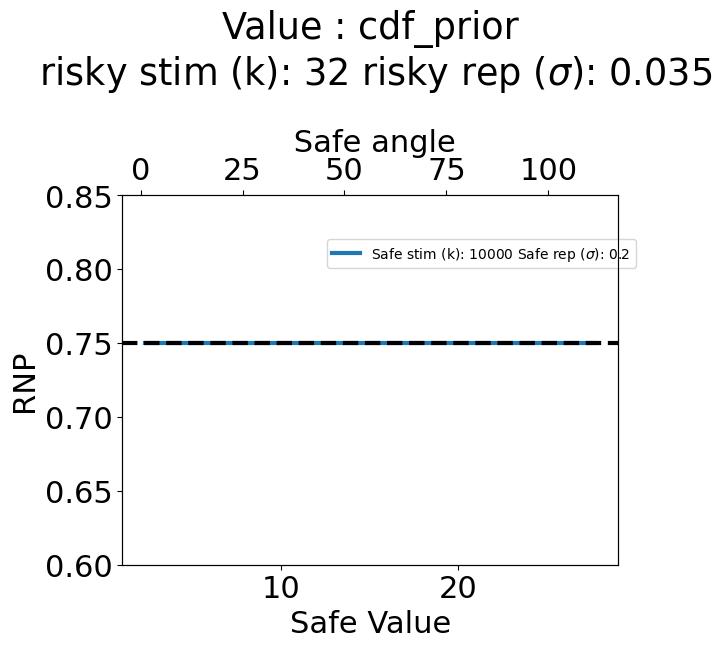

In [14]:

# setting parameters
experimentEffects = "00to180"#"00to45"
risk_prob = 0.75
type = "cdf_prior" 

# changeable parameters
high_stim_list = [32]
low_stim_list = [10000]
high_rep_list = [0.2]
low_rep_list = [0.035]

fig = plt.figure()
ax1 = fig.add_subplot(111)

for high_stim_noise in high_stim_list:
    for high_rep_noise in high_rep_list:
        for low_stim_noise in low_stim_list:
            for low_rep_noise in low_rep_list:

                safeNoise = [low_stim_noise, high_rep_noise]
                riskyNoise = [high_stim_noise, low_rep_noise]

                safe_angles, safeVals, rnp = find_rnp_diffNoises(safeNoise, riskyNoise, type, risk_prob, experimentEffects)

                ax1.set_ylim(0.6, 0.85)

                text = "Safe stim (k): "+ str(safeNoise[0])+" Safe rep ($\sigma$): "+str(safeNoise[1])
                # text = "Risky stim (k): "+ str(riskyNoise[0])+"; Risky rep ($\sigma$): "+str(riskyNoise[1])


                ax1.plot(safeVals[:], rnp[:], label = text)

                ax2 = ax1.twiny()
                if (type=="prior" or type=="linearPrior" or type=="curvedPrior"):
                    ax2.set_xlim(max(safe_angles*90./np.pi), min(safe_angles*90./np.pi))
                ax2.plot(safe_angles*90./np.pi, np.ones(len(safe_angles))/1.3, alpha=0.0)

ax1.axhline(risk_prob, c='k', ls='--')
ax1.legend(bbox_to_anchor=(1.05, 0.9), prop={'size': 10})

ax2.set_xlabel("\n Safe angle")
ax1.set_xlabel("Safe Value")
ax1.set_ylabel("RNP")
# if len(safeNoise[0])==1 and len(safeNoise[1])==1:
# ax1.set_title("Value : " + type + "\n safe stim (k): "+str(safeNoise[0])+"; safe rep ($\sigma$): "+str(safeNoise[1]))
# else:
ax1.set_title("Value : " + type + "\n risky stim (k): "+str(riskyNoise[0])+" risky rep ($\sigma$): "+str(riskyNoise[1]))
plt.savefig('/Users/sbedi/Downloads/testfig.png',dpi=300, bbox_inches = "tight")

# just for a safe angle

0.749592290155921

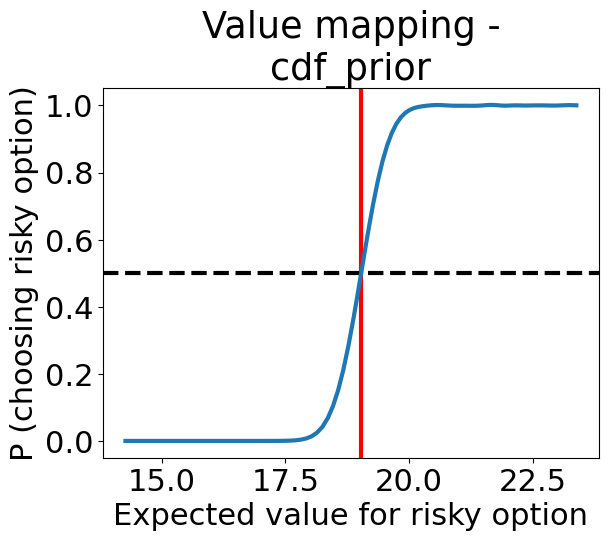

In [12]:
# setting parameters
experimentEffects = "00to180"#"00to45"
risk_prob = 0.75
type = "cdf_prior" 

stim_noise = 1000
rep_noise = 0.07
start = 80

# Getting all the values from actual transformation
interval = 50
rangeOri = np.linspace(start/90., (start+interval)/90., 100)*np.pi
val_range = tools.value_function_ori(rangeOri, type)
safeVal = val_range[0]
riskyVal_range = risk_prob*tools.value_function_ori(rangeOri, type)


# getting inferred safe values
safe_value, safe_prob = model.value_bayesian_decoding(rangeOri[0], stim_noise, rep_noise, type)
risky_value, risky_prob = model.risky_value_dist((rangeOri), stim_noise, rep_noise, risk_prob, type)


# # Risk attitudes 
p_chose_risky = tools.diff_dist(safe_value, risky_prob, safe_prob)

# The value of the safe option
plt.axvline(safeVal, c='r', label = "safe option\n value")
# Where the risky option value is the same as the safe option value,
# the probability of chosing should have been 0.5 i there were no biases at all.
plt.axhline(0.5, c='k', ls='--')
# plt.ylim(0.4,0.6)

# Plotting the risky option value throughout the range and comparing where it crosses the 0.5 probability mark
# and whether it is equal to the actual rational equilibrium that would have been without biases.
plt.plot(riskyVal_range, np.squeeze(p_chose_risky))#, label=['rep',kappa_r, "stim (deg)",round(kappa_s*180,2)])

plt.xlabel("Expected value for risky option")
plt.ylabel("P (choosing risky option)")
plt.title("Value mapping -\n" + type) 

# plt.savefig('/Users/sbedi/Downloads/testfig.png',dpi=300, bbox_inches = "tight")

tools.get_rnp(safeVal, val_range, p_chose_risky, risk_prob)

